In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import h5py
import os
from six.moves import cPickle as pickle

## Load Mat
Firstly we have to load the digitStruct.mat and prepare it for the analysis.

In [5]:
train_digitStruct = h5py.File('train/digitStruct.mat')
print(train_digitStruct['digitStruct']['bbox'].shape)

(33402, 1)


The file has 33402 entries. In the next step, I will create some helper methods to read the attributes of every images like name, label, top, left, width and height.

In [6]:
#Helper Methods to read attributes of digitStruct.mat
def getSingleAttribute(struct, index, attr):
    attribute = struct[struct['digitStruct']['bbox'][index][0]][attr].value.squeeze()
    if attribute.dtype == 'float64':
        return attribute.reshape(-1)
    else:
        return np.array([struct[x].value for x in attribute]).squeeze()

def getName(struct, index):
    return struct[struct['digitStruct']['name'][index][0]].value.tostring()

def getAttributes(struct, index):
    image = getName(struct, index)
    label = getSingleAttribute(struct, index, 'label')
    for i in range(len(label)):
        if label[i] == 10:
            label[i] =0
    top = getSingleAttribute(struct, index, 'top')
    left = getSingleAttribute(struct, index, 'left')
    width = getSingleAttribute(struct, index, 'width')
    height = getSingleAttribute(struct, index, 'height')
    size = len(top)
    return image, label, top, left, width, height, size



Before I extract the features of the dataset, I need to know the max size of each attribute in order to prepare the numpy arrays.

In [7]:
label_minsize = 0

for i in range(33402):
    label_length = len(getSingleAttribute(train_digitStruct, i, 'label'))
    if label_length > label_minsize:
        label_minsize = label_length
   
print(label_minsize)

KeyboardInterrupt: 

Through this analysis we know that we the max array size of each feature is 6.

In [43]:
import time
def loadMat(path):
    start = time.time()
    digitStruct = h5py.File(path)
    if path == 'extra/digitStruct.mat':
        indices = 20000
    else:    
        indices = digitStruct['digitStruct']['bbox'].shape[0]
        
    images = np.zeros(shape=indices, dtype=str)
    labels = np.zeros(shape=(indices, 6), dtype=float)
    labels.fill(10)
    tops = np.zeros(shape=(indices, 6), dtype=float)
    lefts = np.zeros(shape=(indices, 6), dtype=float)
    widths = np.zeros(shape=(indices, 6), dtype=float)
    heights = np.zeros(shape=(indices, 6), dtype=float)
    sizes = np.empty(shape=indices, dtype=int)
    for index in range(indices):
        try:
            image, label, top, left, width, height, size = getAttributes(digitStruct, index)
            images[index] = image
            labels[index][:label.shape[0]] = label
            tops[index][:top.shape[0]] = top
            lefts[index][:left.shape[0]] = left
            widths[index][:width.shape[0]] = width
            heights[index][:height.shape[0]] = height
            sizes[index] = size
        except Exception, e:
            print(e)
            break
            

    print("Finished with " + path + " after " + str(time.time() - start) + " seconds. (" + str(indices)+ ")")
    return images, labels, tops, lefts, widths, heights, sizes

In [44]:
traindata = loadMat('train/digitStruct.mat')
#testdata = loadMat('test/digitStruct.mat')
#extradata = loadMat('extra/digitStruct.mat')

Finished with train/digitStruct.mat after 228.844589949 seconds. (33402)


In [10]:
def createFeaturesDict(dataset):
    return {
        'images': dataset[0],
        'labels': dataset[1],
        'tops': dataset[2],
        'lefts': dataset[3],
        'widths': dataset[4],
        'heights': dataset[5],
        'sizes': dataset[6]
    }

def maybePickle(training, testing, valid):
    pickleFile = 'svhn.pickle'
    if os.path.exists(pickleFile):
        print('The file ' + pickleFile + ' is already present.')
    else:
        print('The file ' + pickleFile + ' will be created.')
        data = {
            'training': createFeaturesDict(training), 
            'testing': createFeaturesDict(testing),
            'extra': createFeaturesDict(valid)
        }
        try:
            with open(pickleFile, 'wb') as f:
              pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
        except Exception as e:
            print('Unable to save data to', pickleFile, ':', e)

In [40]:
def splitInValidAndExtra(dataset):
    valid = []
    predict = []
    for index in range(len(dataset[0])):
        image = dataset[0][index]
        label = dataset[1][index]
        top = dataset[2][index]
        left = dataset[3][index]
        width = dataset[4][index]
        height = dataset[5][index]
        size = dataset[6][index]
    
        if index < 15000:
            valid.append([image, label, top, left, width, height, size])
        else:
            predict.append([image, label, top, left, width, height, size])
        
    return valid, predict

valid, predict = splitInValidAndExtra(extradata)
print(len(valid))
print(predict)

    

15000
[['1', array([  5.,   7.,  10.,  10.,  10.,  10.]), array([ 1.,  2.,  0.,  0.,  0.,  0.]), array([  2.,  30.,   0.,   0.,   0.,   0.]), array([ 26.,  18.,   0.,   0.,   0.,   0.]), array([ 37.,  37.,   0.,   0.,   0.,   0.]), 2], ['1', array([  2.,   0.,   9.,  10.,  10.,  10.]), array([ 41.,  36.,  23.,   0.,   0.,   0.]), array([  35.,   98.,  136.,    0.,    0.,    0.]), array([ 65.,  47.,  56.,   0.,   0.,   0.]), array([ 91.,  91.,  91.,   0.,   0.,   0.]), 3], ['1', array([  9.,   5.,   6.,  10.,  10.,  10.]), array([ 15.,  14.,  14.,   0.,   0.,   0.]), array([ 20.,  34.,  50.,   0.,   0.,   0.]), array([ 18.,  18.,  18.,   0.,   0.,   0.]), array([ 32.,  32.,  32.,   0.,   0.,   0.]), 3], ['1', array([  5.,   2.,   1.,  10.,  10.,  10.]), array([ 14.,  14.,  13.,   0.,   0.,   0.]), array([ 11.,  35.,  61.,   0.,   0.,   0.]), array([ 20.,  21.,  15.,   0.,   0.,   0.]), array([ 31.,  31.,  31.,   0.,   0.,   0.]), 3], ['1', array([  5.,   1.,  10.,  10.,  10.,  10.]), ar

In [8]:
maybePickle(traindata, testdata, extradata)

The file svhn.pickle will be created.


In [9]:
pickleFile = open('svhn.pickle', 'r')
data = pickle.load(pickleFile)
print(data.keys())

['training', 'testing', 'valid']


In [10]:
training = data['training']
testing = data['testing']
valid = data['valid']

## Count of characters

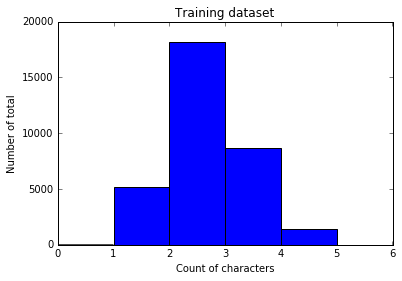

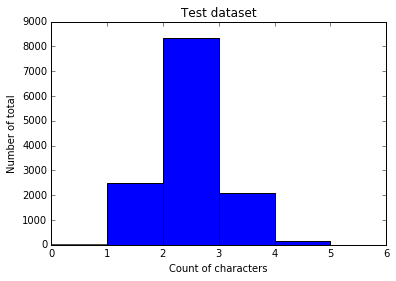

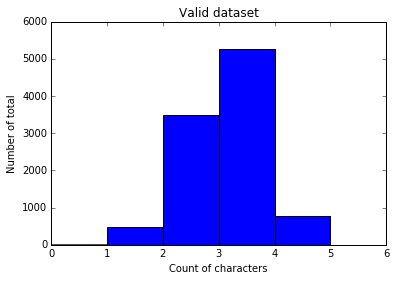

In [11]:
plt.title("Training dataset")
plt.xlabel("Count of characters")
plt.ylabel("Number of total")
plt.hist(training['sizes'], [0,1,2,3,4,5,6])
plt.show()

plt.title("Test dataset")
plt.xlabel("Count of characters")
plt.ylabel("Number of total")
plt.hist(testing['sizes'], [0,1,2,3,4,5,6])
plt.show()

plt.title("Valid dataset")
plt.xlabel("Count of characters")
plt.ylabel("Number of total")
plt.hist(valid['sizes'], [0,1,2,3,4,5,6])
plt.show()


## Attributes Exploration

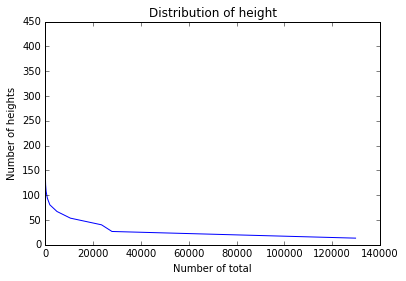

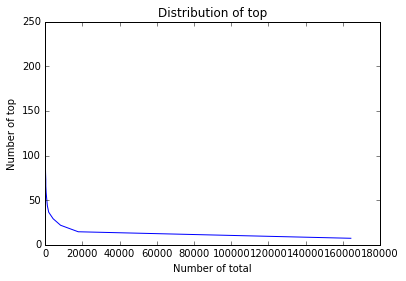

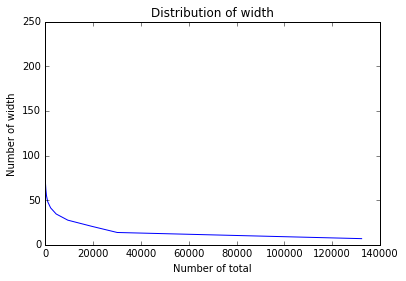

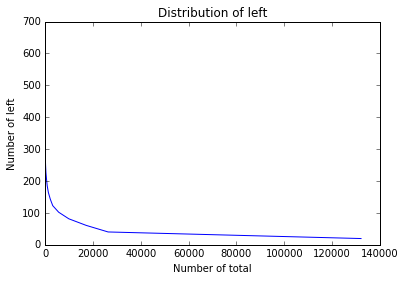

In [12]:
heightshist = np.histogram(training['heights'], bins=30)
plt.title("Distribution of height")
plt.xlabel("Number of total")
plt.ylabel("Number of heights")
x = np.array(heightshist[0])
y = np.array(heightshist[1][1:])
plt.plot(x,y)
plt.show()

topshist = np.histogram(training['tops'], bins=30)
plt.title("Distribution of top")
plt.xlabel("Number of total")
plt.ylabel("Number of top")
x = np.array(topshist[0])
y = np.array(topshist[1][1:])
plt.plot(x,y)
plt.show()

widthshist = np.histogram(training['widths'], bins=30)
plt.title("Distribution of width")
plt.xlabel("Number of total")
plt.ylabel("Number of width")
x = np.array(widthshist[0])
y = np.array(widthshist[1][1:])
plt.plot(x,y)
plt.show()

leftshist = np.histogram(training['lefts'], bins=30)
plt.title("Distribution of left")
plt.xlabel("Number of total")
plt.ylabel("Number of left")
x = np.array(leftshist[0])
y = np.array(leftshist[1][1:])
plt.plot(x,y)
plt.show()





In [13]:
print(np.mean(heightshist[1][1:]))
print(np.mean(topshist[1][1:]))
print(np.mean(widthshist[1][1:]))
print(np.mean(leftshist[1][1:]))

208.216666667
113.15
106.95
318.816666667
